In [4]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

In [5]:
f = open('models/waterer.ply')
lines = f.readlines()

In [6]:
# inverse homogeneous matrix fuction
from numpy.linalg import inv
def inv_homogenous_matrix(rvec, tvec):
    #https://mathematica.stackexchange.com/questions/106257/how-do-i-get-the-inverse-of-a-homogeneous-transformation-matrix
    rvec_out = inv(rvec)
    tvec_out = np.matmul(-1*rvec_out, tvec)
    return rvec_out, tvec_out

In [90]:
# read points from model.ply

points = []
point_num = int(lines[3].split()[-1])
print("point count: ", point_num)

sample_rate = 10

closest_point_to_zero = np.array([1000.0, 1000.0, 1000.0])

for idx, line in enumerate(lines[17:17+point_num]):

    if idx % sample_rate == 0:
        x, y, z = line.split(' ')[:3]
        x = float(x)/1000
        y = float(y)/1000
        z = float(z)/1000
        # you need to shift all model points cuz zero is not at the bottom of your model
        # gazebo uses model bottom as zero point
        points.append([x, y, z, 1.0])
        if(x**2+y**2+z**2 < np.sum(closest_point_to_zero**2)):
            closest_point_to_zero[0] = x
            closest_point_to_zero[1] = y
            closest_point_to_zero[2] = z

points = np.array(points)

# shift in z direction to move model refernce point to the bottom of model
model_zoffset = np.min(points[:, 2])
#points[:, 2] -= model_zoffset
print("model z offset:", model_zoffset)
print(points)
print("z min: ", np.min(points[:, 2]))
print("z max: ", np.max(points[:, 2]))

point count:  22831
model z offset: -0.0967125
[[-0.006631  -0.0409674 -0.0766654  1.       ]
 [-0.0205098 -0.0254599 -0.0940682  1.       ]
 [ 0.0213234  0.0218684 -0.0930298  1.       ]
 ...
 [ 0.0024658  0.0793528  0.0075803  1.       ]
 [ 0.0294175  0.046834  -0.0613853  1.       ]
 [ 0.0114874  0.0682429 -0.0459915  1.       ]]
z min:  -0.0967125
z max:  0.09647700000000001


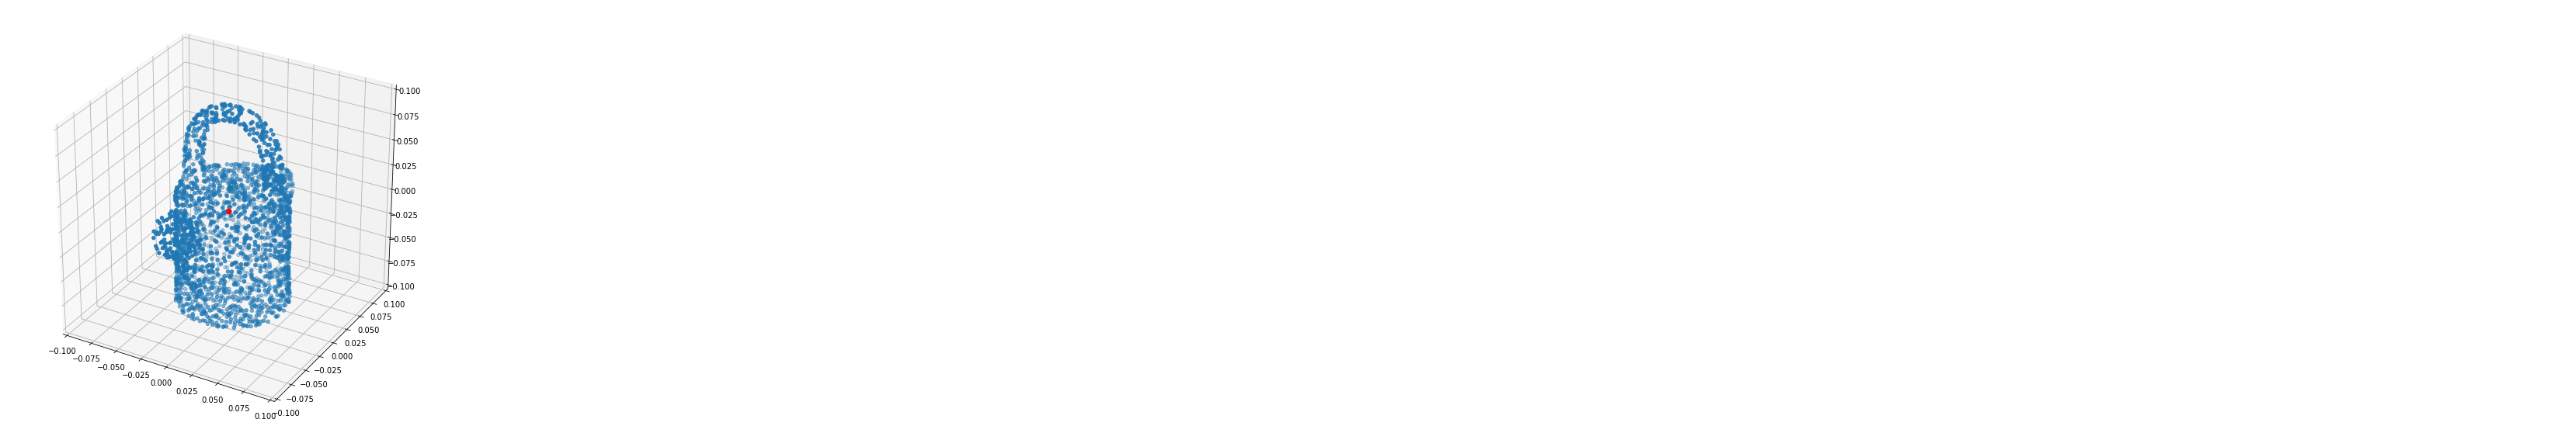

In [8]:
# show read points from .ply file

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10)) # specify figsize or your image will be distorted

ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.scatter(0, 0, 0, c = 'red', s = 50)
ax.scatter(0.000559, 0.001484, 0.022542000000000003, c = 'green', s = 50)
ax.set_xlim3d(-0.1, 0.1)
ax.set_ylim3d(-0.1, 0.1)
ax.set_zlim3d(-0.1, 0.1)
plt.show()
fig.savefig('result/waterer_dots_zero_point.png')

In [105]:
# camera coordinate and object coordinate in gazebo
'''
test data information

camera rotation only (model pos = (0, 0, 0, 0, 0, 0))
   x,    y,    z,  roll, pitch,  yaw, img
   1,  0.5,  1.0,   0.0,   0.5, -2.5, 0002.png
 0.5,  0.5,  1.0,   0.0,   0.8, -2.5, 0003.png
-0.5,  0.5,  0.5,   0.0,   0.4, -0.9, 0004.png
 
'''
'''
test_data = [[   1,  0.5,  1.0,   0.0,   0.5, -2.5, "rgb/0002.png"],
             [ 0.5,  0.5,  1.0,   0.0,   0.8, -2.5, "rgb/0003.png"],
             [-0.5,  0.5,  0.5,   0.0,   0.4, -0.9, "rgb/0004.png"]]
'''

camera_coords = [[   1,  0.5,  1.0,   0.0,   0.5, -2.5],
                 [ 0.5,  0.5,  1.0,   0.0,   0.8, -2.5],
                 [-0.5,  0.5,  0.5,   0.0,   0.4, -0.9]]

object_coords = [[0.0,  0.0,  0.0 - model_zoffset,   0.0,   0.0, 0.0],
                 [0.0,  0.0,  0.0 - model_zoffset,   0.0,   0.0, 0.0],
                 [0.0,  0.0,  0.0 - model_zoffset,   0.0,   0.0, 0.0]]

img_name = ["rgb/0002.png", "rgb/0003.png", "rgb/0004.png"]

data_idx = 2


In [106]:
# calculate world to camera rvec, tvec
roll, pitch, yaw = camera_coords[data_idx][3:6]

Rx = [[1,            0,             0],
      [0, np.cos(roll), -np.sin(roll)],
      [0, np.sin(roll),  np.cos(roll)]]

Ry = [[ np.cos(pitch), 0, np.sin(pitch)],
      [0             , 1,             0],
      [-np.sin(pitch), 0, np.cos(pitch)]]

Rz = [[np.cos(yaw), -np.sin(yaw), 0],
      [np.sin(yaw),  np.cos(yaw), 0],
      [          0,            0, 1]]


camera_rvec = np.matmul( np.array(Rz), np.matmul(np.array(Ry), np.array(Rx)) ) #gazebo rotation order x->y->z
camera_tvec = np.array(camera_coords[data_idx][0:3])
print(camera_rvec, camera_tvec)

camera_rvec, camera_tvec = inv_homogenous_matrix(camera_rvec, camera_tvec)
print(camera_rvec, camera_tvec)

trivial_row = np.array([0, 0, 0, 1]).reshape((1, 4))
world_to_cam_extrinsic = np.append(camera_rvec, camera_tvec.reshape((3, 1)), axis=1)
world_to_cam_extrinsic = np.append(world_to_cam_extrinsic, trivial_row, axis=0)

print(world_to_cam_extrinsic)

[[ 0.5725407   0.78332691  0.24206632]
 [-0.72149186  0.62160997 -0.30504187]
 [-0.38941834  0.          0.92106099]] [-0.5  0.5  0.5]
[[ 5.72540695e-01 -7.21491862e-01 -3.89418342e-01]
 [ 7.83326910e-01  6.21609968e-01 -2.00254219e-17]
 [ 2.42066323e-01 -3.05041867e-01  9.21060994e-01]] [ 0.84172545  0.08085847 -0.1869764 ]
[[ 5.72540695e-01 -7.21491862e-01 -3.89418342e-01  8.41725450e-01]
 [ 7.83326910e-01  6.21609968e-01 -2.00254219e-17  8.08584707e-02]
 [ 2.42066323e-01 -3.05041867e-01  9.21060994e-01 -1.86976402e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [107]:
# calculate object to world rvec, tvec
roll, pitch, yaw = object_coords[data_idx][3:6]

Rx = [[1,            0,             0],
      [0, np.cos(roll), -np.sin(roll)],
      [0, np.sin(roll),  np.cos(roll)]]

Ry = [[ np.cos(pitch), 0, np.sin(pitch)],
      [0             , 1,             0],
      [-np.sin(pitch), 0, np.cos(pitch)]]

Rz = [[np.cos(yaw), -np.sin(yaw), 0],
      [np.sin(yaw),  np.cos(yaw), 0],
      [          0,            0, 1]]


object_rvec = np.matmul( np.array(Rz), np.matmul(np.array(Ry), np.array(Rx)) ) #gazebo rotation order x->y->z
object_tvec = np.array(object_coords[data_idx][0:3])
print(object_rvec, object_tvec)


object_to_world_extrinsic = np.append(object_rvec, object_tvec.reshape((3, 1)), axis=1)

trivial_row = np.array([0, 0, 0, 1]).reshape((1, 4))
object_to_world_extrinsic = np.append(object_rvec, object_tvec.reshape((3, 1)), axis=1)
object_to_world_extrinsic = np.append(object_to_world_extrinsic, trivial_row, axis=0)

print(object_to_world_extrinsic)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [0.        0.        0.0967125]
[[1.        0.        0.        0.       ]
 [0.        1.        0.        0.       ]
 [0.        0.        1.        0.0967125]
 [0.        0.        0.        1.       ]]


In [108]:
# combine object_to_world RT and world_to_camera RT
rot_to_cam = np.array([[ 0,-1, 0, 0],
                       [ 0, 0,-1, 0],
                       [ 1, 0, 0, 0],
                       [ 0, 0, 0, 1]])

'''
    combined extrinsic = rot_to_cam * world_to_came * object_to_world
'''
combined_extrinsic = np.matmul(world_to_cam_extrinsic, object_to_world_extrinsic)
combined_extrinsic = np.matmul(rot_to_cam, combined_extrinsic)
print(combined_extrinsic)

[[-7.83326910e-01 -6.21609968e-01  2.00254219e-17 -8.08584707e-02]
 [-2.42066323e-01  3.05041867e-01 -9.21060994e-01  9.78982906e-02]
 [ 5.72540695e-01 -7.21491862e-01 -3.89418342e-01  8.04063828e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [109]:
# model points coords to camera frame coords
points_cam_frame = np.matmul(combined_extrinsic, points.transpose())
print(points_cam_frame.transpose()[:, 0:3])

[[-0.05019849  0.15762017  0.85967987]
 [-0.04896646  0.18173924  0.84732213]
 [-0.11115528  0.18509351  0.83672198]
 ...
 [-0.13211649  0.11452541  0.74527129]
 [-0.13301447  0.16160324  0.81102076]
 [-0.13227733  0.1582955   0.77931407]]


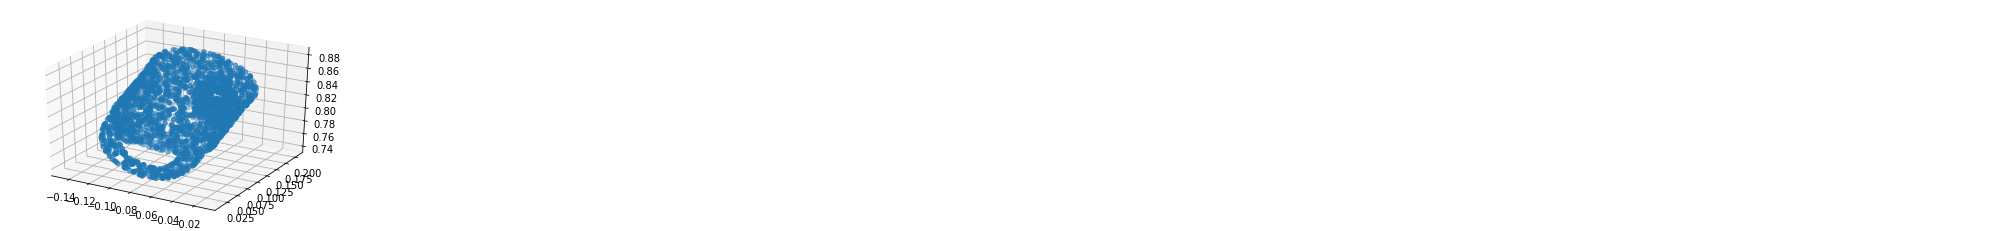

In [110]:
points_cam = points_cam_frame.transpose()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_cam[:, 0], points_cam[:, 1], points_cam[:, 2])
#ax.set_xlim3d(-101, 101)
#ax.set_ylim3d(-102, 102)
#ax.set_zlim3d(-103, 103)
plt.show()

In [111]:
intrinsic = [572.411400033838, 0.0, 320.0, 0.0, 572.4114000338382, 240, 0.0, 0.0, 1.0]
#intrinsic = [572.4114, 0.0, 325.2611, 0.0, 573.57043, 242.04899, 0.0, 0.0, 1.0]
intrinsic = np.array(intrinsic).reshape((3, 3))
print(intrinsic)

[[572.41140003   0.         320.        ]
 [  0.         572.41140003 240.        ]
 [  0.           0.           1.        ]]


In [112]:
pixel_pos = np.matmul(intrinsic, points_cam_frame[0:3, :])
print(pixel_pos.transpose())

[[246.36337281 296.54675077   0.85967987]
 [243.11411777 307.38692134   0.84732213]
 [204.12448481 306.76291119   0.83672198]
 ...
 [162.8618286  244.42076093   0.74527129]
 [183.38764223 287.14851877   0.81102076]
 [173.66345208 277.64552318   0.77931407]]


In [113]:
img = cv2.imread(img_name[data_idx])
print(img.shape)

(480, 640, 3)


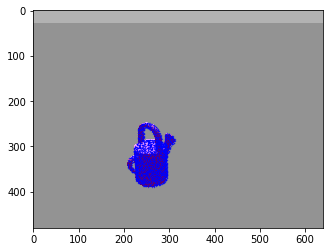

In [114]:
plt.imshow(img)
for row in pixel_pos.transpose():
    row[0] /= row[2]
    row[1] /= row[2]
    row[2] /= row[2]
    #print(row)
    if abs(row[0]) < 1000:
        #pass
        plt.scatter([row[0]], [row[1]], s = 0.1, c = 'blue')
plt.show()
#plt.savefig('result/mapping result.png')